# Quickstart tutorial

Welcome to the quickstart tutorial to Esmraldi! If you have comments or suggestions, please don’t hesitate to reach out. 
This tutorial contains the key steps of the imaging processing workflow leading to the joint analysis of a MALDI image with another image. It uses a basic MALDI dataset along with a synthetic image mimicking an optical image obtained from another modality. 

Let's set-up our notebook to start:

In [11]:
%load_ext autoreload
%autoreload 2

import sys, os
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import string
import SimpleITK as sitk

rootpath = "../../"
sys.path.append(os.path.join(os.path.dirname(os.path.abspath("__file__")), rootpath))

def display_image(image):
    plt.axis("off")
    plt.imshow(image, cmap="gray")
    plt.show()

def display_images(*images):
    fig, ax = plt.subplots(1, len(images))
    for i in range(len(images)):
        ax[i].axis('off')
        ax[i].imshow(images[i], cmap="gray")
        ax[i].text(0.4, -0.2, "(" + string.ascii_lowercase[i] + ")", transform=ax[i].transAxes, size=18)
    plt.show()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload



## Input, Visualization

The data is available in the `data` directory. 
First, read the data and display the spectrum of the first pixel:

(9, 2, 8399)


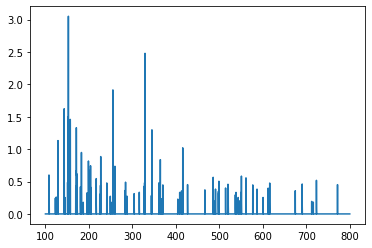

In [12]:
import esmraldi.imzmlio as io

imzml = io.open_imzml(rootpath + "data/Example_Continuous.imzML")
spectra = io.get_spectra(imzml)

print(spectra.shape)
mz_first, intensities_first = spectra[0, 0], spectra[0, 1]
plt.plot(mz_first, intensities_first)
plt.show()

The variable `spectra` is a 3D numpy array, where the first dimension corresponds to pixels, the second dimension to *m/z* or intensities, and the last dimension to their associated values. Here, this array contains 9 pixels, and each spectrum has 8399 points.

Then, we display the image of the ion of *m/z* 328.9 +/- 0.25:

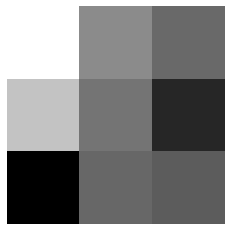

In [3]:
image = io.get_image(imzml, 328.9, 0.25)
display_image(image)

The image is a 3x3 array of various intensities.

Now, we read the optical image:

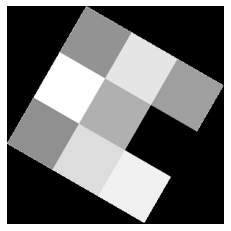

In [4]:
optical_image = plt.imread(rootpath + "data/Example_Optical.png")
display_image(optical_image)


## Spectra processing

### Peak detection

The next step is to detect peaks across all spectra. Our approach is based on [topographical prominence](https://en.wikipedia.org/wiki/Topographic_prominence) values. More specifically, we define the **local** prominence as the ratio between the prominence and the estimated local noise in the signal. The local noise $\sigma$ is estimated as the median absolute deviations in a window of length $w$. Let $f$ be the local prominence factor, the local maxima whose intensity is above $f * \sigma$ are considered as peaks.

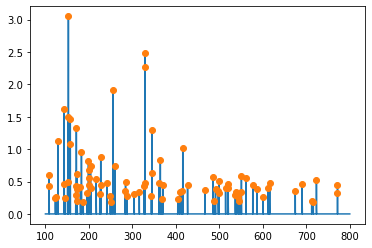

In [5]:
import esmraldi.spectraprocessing as sp

prominence_local_factor = 5
window_length = 7000

detected_mzs = sp.spectra_peak_mzs_adaptative(spectra, factor=prominence_local_factor, wlen=window_length)
detected_mz_first = detected_mzs[0]
indices = np.in1d(mz_first, detected_mz_first)
detected_intensities_first = intensities_first[indices]

plt.plot(mz_first, intensities_first, detected_mz_first, detected_intensities_first, "o")
plt.show()

The original spectrum is displayed in blue, and the detected peaks are highlighted by orange dots.


### Spectra alignment
Next, the spectra need to be realigned to compensate for *m/z* differences between pixels, due to instrumentation differences, or sample inhomogeneity.

Groups of close *m/z* values are made with a tolerance given by the *step* parameter. The median *m/z* value in each group is taken as reference for the alignment procedure.

In [6]:
realigned_spectra = sp.realign_mzs(spectra, detected_mzs, reference="median", nb_occurrence=1, step=0.05)
mzs = realigned_spectra[0, 0, :]
print(realigned_spectra.shape)

130
(9, 2, 130)


After the realignment, 121 peaks are detected (vs. the initial 8399 peaks).

## Segmentation

Next, a representative image is extracted from the set of MALDI ion images. This is achieved by **region growing on a subset of relevant images**, i.e. non-noisy images.

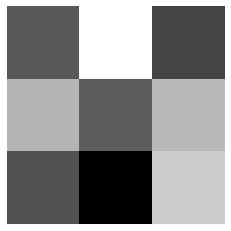

In [7]:
import esmraldi.segmentation as seg

maldi_image = io.get_images_from_spectra(realigned_spectra, (3,3))
maldi_image = io.normalize(maldi_image)

# Relevant images
spatially_coherent = seg.find_similar_images_spatial_coherence(maldi_image, 0, quantiles=[60, 70, 80, 90])
# Mean image
mean_image = np.average(spatially_coherent, axis=-1)

# Region growing
seeds = set(((1, 1), (0, 0)))
list_end, _ = seg.region_growing(spatially_coherent, seedList=seeds, lower_threshold=50)
x = [elem[0] for elem in list_end]
y = [elem[1] for elem in list_end]
mask = np.ones_like(mean_image)
mask[x, y] = 0
segmented_image = np.ma.array(mean_image, mask=mask)
segmented_image = segmented_image.filled(0)

display_image(segmented_image)

## Registration

At this stage, both shapes in the optical and MALDI  images can be matched. Registration methods aim at finding the transform which best aligns two objects. The transform parameters are estimated by optimizing a metric which quantifies the similarity between both images. In our case, we register **the MALDI segmented image onto the optical image**.

The registration is based on the [SimpleITK](https://simpleitk.org/) library. We choose the following registration components:

* **transform**: rigid transform (translation, scaling, rotation)
* **metric**: Mattes mutual information
* **optimizer**: regular step gradient descent
* **interpolator**: nearest neighbor

The input images must be instances of the [SimpleITK.Image](https://simpleitk.org/doxygen/latest/html/classitk_1_1simple_1_1Image.html) class.

Each component takes various parameters. For the metric, the *number of bins* defines the marginal and joint histograms, the *sampling percentage* describes the proportion of pixels in the image used to compute the metric and *seed* is used to initialize the random number generator to create the sample points. Regarding the optimizer, the *learning rate* defines the initial step length, the *relaxation factor* the factor reducing the step length each time the derivative sign changes, and *min step* the stop criterion for the optimizer. 

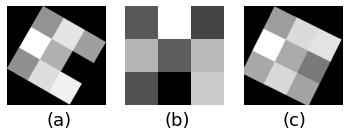

In [8]:
import esmraldi.registration as reg
import esmraldi.imageutils as utils

segmented_itk = sitk.Cast(sitk.GetImageFromArray(segmented_image), sitk.sitkFloat32)
optical_itk = sitk.Cast(sitk.GetImageFromArray(optical_image), sitk.sitkFloat32)
segmented_itk = utils.resize(segmented_itk, optical_itk.GetSize())
segmented_itk = sitk.Cast(segmented_itk, sitk.sitkFloat32)

number_bins = 8
sampling_percentage = 0.1
registration = reg.register(optical_itk, segmented_itk, number_bins, sampling_percentage, seed=0, learning_rate=0.8, relaxation_factor=0.8, min_step=0.0001)
registered_seg_itk = registration.Execute(segmented_itk)
registered_seg_image = sitk.GetArrayFromImage(registered_seg_itk)

display_images(optical_image, segmented_image, registered_seg_image)

(a&#8291;) Optical fixed image, (b) original MALDI segmented image and (c) registered MALDI image.

Finally, we apply the registration to the original MALDI image:

In [9]:
registered_itk = sitk.GetImageFromArray(maldi_image)
registered_itk = utils.resize(registered_itk, optical_itk.GetSize())
registered_itk = sitk.Cast(registered_itk, sitk.sitkFloat32)
size = registered_itk.GetSize()
size = [size[2], size[1], size[0]]
out_register = sitk.Image(size, registered_itk.GetPixelID() )

for i in range(registered_itk.GetSize()[0]):
    slice = registered_itk[i, :, :]
    slice.SetSpacing(optical_itk.GetSpacing())
    slice_registered = registration.Execute(slice)
    slice_registered = sitk.JoinSeries(slice_registered)
    out_register = sitk.Paste(out_register, slice_registered, slice_registered.GetSize(), destinationIndex=[0, 0, i])

registered_image = np.transpose(sitk.GetArrayFromImage(out_register), (1, 2, 0))

## Joint statistical analysis

The final step of the workflow is to find the MALDI ion images whose distribution correlate with the optical image.

Here, we choose non-negative Principal Component Analysis (PCA) to find spatial correlations. 
First, the registered MALDI image is factorized, then, the MRI image is projected into the reduced space, and correlations are established based on the distance in this space.

We search for the 3 ion images which are closest to the optical image:

(130, 89700)


[[ -6.2446012  17.279459   -8.177338  -22.472115   -2.82487  ]]
Closest m/z ratio  [781.3334  241.33334 464.9167 ]


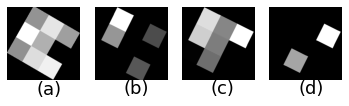

In [10]:
import esmraldi.fusion as fusion

optical_flatten = fusion.flatten(optical_image)
maldi_flatten = fusion.flatten(registered_image, is_spectral=True)

# Reduction by NMF
print(maldi_flatten.shape)
fit_red = fusion.pca(maldi_flatten, n=5)
reduction = fit_red.transform(maldi_flatten)
point_optical = fit_red.transform(optical_flatten)
weights = [1 for i in range(reduction.shape[1])]

similar_images, similar_mzs, distances = fusion.select_images(registered_image, point_optical, reduction, weights, mzs, labels=None, top=None)

print("Closest m/z ratio ", similar_mzs[:3])
display_images(optical_image, similar_images[..., 0], similar_images[..., 1], similar_images[..., 2])

(a&#8291;) Optical image, (b-d) MALDI ion images which are closest to the optical image.